In [41]:
import uproot
import awkward as ak
import numpy as np
import sklearn.metrics as m
# import boost_histogram as bh
import glob
import os
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib as mpl
# from cycler import cycler
import mplhep as hep
from types import SimpleNamespace
# use_helvet = True  ## true: use helvetica for plots, make sure the system have the font installed
# if use_helvet:
#     CMShelvet = hep.style.CMS
#     CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
#     plt.style.use(CMShelvet)
# else:
#     plt.style.use(hep.style.CMS)

In [42]:
files_list = glob.glob("/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/ak8_MD_inclv8std_nonmd_test.test/*.root")
print('all the predict files are: ', files_list)

all the predict files are:  ['/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/ak8_MD_inclv8std_nonmd_test.test/pred_qcd1000to1400.root', '/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/ak8_MD_inclv8std_nonmd_test.test/pred_qcd300to470.root', '/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/ak8_MD_inclv8std_nonmd_test.test/pred_ttbar.root', '/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/ak8_MD_inclv8std_nonmd_test.test/pred_qcd470to600.root', '/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/ak8_MD_inclv8std_nonmd_test.test/pred_qcd1800to2400.root', '/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/ak8_MD_inclv8std_nonmd_test.test/pred_qcd800to1000.root', '/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/ak8_MD_inclv8std_nonmd_test.test/pred_qcd600to800.root', '/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/ak8_MD_inclv8std_nonmd_test.test/pred_qcd1400to1800.root', '/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-de

In [43]:
events_bkg = pd.concat([uproot.open(file)["Events"].arrays(library="pd", how="zip") for file in files_list if 'qcd' in file])
events_sig = pd.concat([uproot.open(file)["Events"].arrays(library="pd", how="zip") for file in files_list if 'ttbar' in file])

In [44]:
list(events_sig.columns)

['cls_index',
 'score_label_Top_bWcs',
 'score_label_Top_bWqq',
 'score_label_Top_bWc',
 'score_label_Top_bWs',
 'score_label_Top_bWq',
 'score_label_Top_bWev',
 'score_label_Top_bWmv',
 'score_label_Top_bWtauev',
 'score_label_Top_bWtaumv',
 'score_label_Top_bWtauhv',
 'score_label_Top_Wcs',
 'score_label_Top_Wqq',
 'score_label_Top_Wev',
 'score_label_Top_Wmv',
 'score_label_Top_Wtauev',
 'score_label_Top_Wtaumv',
 'score_label_Top_Wtauhv',
 'score_label_QCD_bb',
 'score_label_QCD_cc',
 'score_label_QCD_b',
 'score_label_QCD_c',
 'score_label_QCD_others',
 'event_no',
 'fj_label',
 'fj_pt',
 'fj_eta',
 'fj_phi',
 'fj_mass',
 'fj_sdmass',
 'fj_sdmass_fromsubjets',
 'fj_gen_mass',
 'fj_genparts_mass',
 'fj_genjet_sdmass',
 'fj_genjet_nomu_sdmass',
 'sample_isQCD',
 'pfParticleNetMassRegressionJetTags_mass',
 'pfMassDecorrelatedParticleNetJetTags_probXbb',
 'pfMassDecorrelatedParticleNetJetTags_probXcc',
 'pfMassDecorrelatedParticleNetJetTags_probXqq',
 'pfMassDecorrelatedParticleNetJet

In [45]:

PN_score_formula = "PN_score = (pfParticleNetJetTags_probTbcq+pfParticleNetJetTags_probTbqq) / (pfParticleNetJetTags_probTbcq+pfParticleNetJetTags_probTbqq+pfParticleNetJetTags_probQCDb+pfParticleNetJetTags_probQCDbb+pfParticleNetJetTags_probQCDc+pfParticleNetJetTags_probQCDcc+pfParticleNetJetTags_probQCDothers)"


ParT_score_formula = "ParT_score = (score_label_Top_bWqq + score_label_Top_bWcs) / (score_label_Top_bWqq + score_label_Top_bWcs + score_label_QCD_bb + score_label_QCD_cc + score_label_QCD_b + score_label_QCD_c + score_label_QCD_others)"
# ParT_score_formula = "ParT_score = (score_label_Top_bWcs + score_label_Top_bWqq + score_label_Top_bWc + score_label_Top_bWs + score_label_Top_bWq + score_label_Top_bWev + score_label_Top_bWmv + score_label_Top_bWtauev + score_label_Top_bWtaumv + score_label_Top_bWtauhv + score_label_Top_Wcs + score_label_Top_Wqq + score_label_Top_Wev + score_label_Top_Wmv + score_label_Top_Wtauev + score_label_Top_Wtaumv + score_label_Top_Wtauhv) / (score_label_Top_bWcs + score_label_Top_bWqq + score_label_Top_bWc + score_label_Top_bWs + score_label_Top_bWq + score_label_Top_bWev + score_label_Top_bWmv + score_label_Top_bWtauev + score_label_Top_bWtaumv + score_label_Top_bWtauhv + score_label_Top_Wcs + score_label_Top_Wqq + score_label_Top_Wev + score_label_Top_Wmv + score_label_Top_Wtauev + score_label_Top_Wtaumv + score_label_Top_Wtauhv + score_label_QCD_bb + score_label_QCD_cc + score_label_QCD_b + score_label_QCD_c + score_label_QCD_others)"
# df_bkg = events_bkg.arrays(library="pd", how="zip")
df_bkg = events_bkg

# eval
df_bkg.eval(PN_score_formula, inplace=True)
df_bkg.eval(ParT_score_formula, inplace=True)

# df_sig = events_sig.arrays(library="pd", how="zip")
df_sig = events_sig
df_sig = df_sig[(df_sig['cls_index'] == 0) | (df_sig['cls_index'] == 1)]
# eval
df_sig.eval(PN_score_formula, inplace=True)
df_sig.eval(ParT_score_formula, inplace=True)


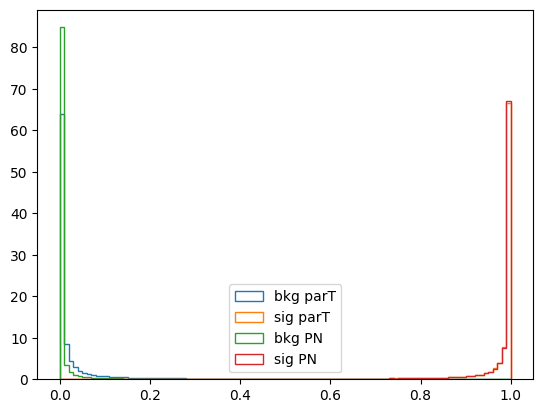

In [46]:
plt.hist(df_bkg['ParT_score'], bins=100, histtype='step', label='bkg parT', density=True)
plt.hist(df_sig['ParT_score'], bins=100, histtype='step', label='sig parT', density=True)
    
plt.hist(df_bkg['PN_score'], bins=100, histtype='step', label='bkg PN', density=True)
plt.hist(df_sig['PN_score'], bins=100, histtype='step', label='sig PN', density=True)

plt.legend()


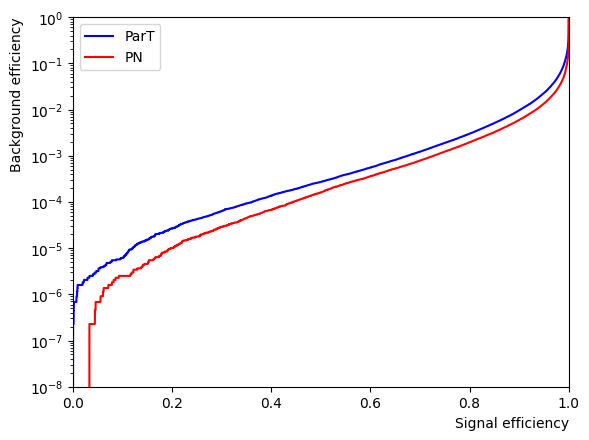

In [47]:
y_ParT_score_sig = df_sig["ParT_score"].to_numpy()
y_ParT_score_bkg = df_bkg["ParT_score"].to_numpy()
y_ParT_score_pred = np.concatenate((y_ParT_score_sig, y_ParT_score_bkg))
y_ParT_score_true = np.concatenate((np.ones_like(y_ParT_score_sig), np.zeros_like(y_ParT_score_bkg)))
    
y_PN_score_sig = df_sig["PN_score"].to_numpy()
y_PN_score_bkg = df_bkg["PN_score"].to_numpy()
y_PN_score_pred = np.concatenate((y_PN_score_sig, y_PN_score_bkg))
y_PN_score_true = np.concatenate((np.ones_like(y_PN_score_sig), np.zeros_like(y_PN_score_bkg)))

from scipy.interpolate import interp1d
fpr_ParT, tpr_ParT, thresholds = m.roc_curve(y_ParT_score_true, y_ParT_score_pred)
fpr_PN, tpr_PN, thresholds = m.roc_curve(y_PN_score_true, y_PN_score_pred)

# 创建一个新的图形和轴对象
fig, ax = plt.subplots()

# 绘制 ROC 曲线
func = interp1d(fpr_ParT, tpr_ParT)
ax.plot(tpr_ParT, fpr_ParT, label='ParT', color='blue')
ax.plot(tpr_PN, fpr_PN, label='PN', color='red')

# ax.plot([0, 1], [0.01, 0.01], ':', color='grey')
# ax.plot([func(0.1), func(0.1)], [0, 0.1], ':', color='grey')
# 设置 x 和 y 轴的标签
ax.set_xlabel('Signal efficiency', ha='right', x=1.0)
ax.set_ylabel('Background efficiency', ha='right', y=1.0)

# 设置图例
ax.legend()

# 设置 y 轴为对数刻度
ax.set_yscale('log')

# 设置 x 和 y 轴的范围
ax.set_xlim(0, 1)
ax.set_ylim(1e-8, 1)
plt.savefig("/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/notebook/roc.pdf")

# 显示图形
plt.show()

In [16]:
df_sig = uproot.open("/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/GloParT_test_with_torch_run_gpus/pred_hww_1.root")["Events"].arrays(filter_name = "/score_/", library="pd")
df_sig['yscore_s'] = df_sig[['score_label_H_WW_cscs','score_label_H_WW_csqq','score_label_H_WW_qqqq','score_label_H_WW_csc','score_label_H_WW_css','score_label_H_WW_csq','score_label_H_WW_qqc','score_label_H_WW_qqs','score_label_H_WW_qqq','score_label_H_WW_csev','score_label_H_WW_qqev','score_label_H_WW_csmv','score_label_H_WW_qqmv','score_label_H_WW_cstauev','score_label_H_WW_qqtauev','score_label_H_WW_cstaumv','score_label_H_WW_qqtaumv','score_label_H_WW_cstauhv','score_label_H_WW_qqtauhv']].sum(axis=1)
df_sig['yscore_b'] = df_sig[['score_label_QCD_bb','score_label_QCD_cc','score_label_QCD_b','score_label_QCD_c','score_label_QCD_others']].sum(axis=1)
df_sig['y_score'] = df_sig['yscore_s']/(df_sig['yscore_s']+df_sig['yscore_b'])

df_bkg = uproot.open("/hpcfs/cms/cmsgpu/zhangzhx/weaver-core-dev/weaver/predict/GloParT_test_with_torch_run_gpus/pred_qcd.root")["Events"].arrays(filter_name = "/score_/", library="pd") 
df_bkg['yscore_s'] = df_bkg[['score_label_H_WW_cscs','score_label_H_WW_csqq','score_label_H_WW_qqqq','score_label_H_WW_csc','score_label_H_WW_css','score_label_H_WW_csq','score_label_H_WW_qqc','score_label_H_WW_qqs','score_label_H_WW_qqq','score_label_H_WW_csev','score_label_H_WW_qqev','score_label_H_WW_csmv','score_label_H_WW_qqmv','score_label_H_WW_cstauev','score_label_H_WW_qqtauev','score_label_H_WW_cstaumv','score_label_H_WW_qqtaumv','score_label_H_WW_cstauhv','score_label_H_WW_qqtauhv']].sum(axis=1)
df_bkg['yscore_b'] = df_bkg[['score_label_QCD_bb','score_label_QCD_cc','score_label_QCD_b','score_label_QCD_c','score_label_QCD_others']].sum(axis=1)
df_bkg['y_score'] = df_bkg['yscore_s']/(df_bkg['yscore_s']+df_bkg['yscore_b'])


/hpcfs/cms/cmsgpu/zhangzhx/miniconda3/envs/ML_env/lib/python3.10/site-packages/uproot/interpretation/library.py:798: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/hpcfs/cms/cmsgpu/zhangzhx/miniconda3/envs/ML_env/lib/python3.10/site-packages/uproot/interpretation/library.py:798: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  out[name] = series[name]
/hpcfs/cms/cmsgpu/zhangzhx/miniconda3/envs/ML_env/lib/python3.10/site-packages/uproot/interpretation/library.py:798: PerformanceWarning: DataFrame is highly f

In [17]:
y_pred_sig = df_sig['y_score']
y_pred_bkg = df_bkg['y_score']
y_pred = np.concatenate([y_pred_sig, y_pred_bkg])
y_true_sig = np.ones(len(y_pred_sig))
y_true_bkg = np.zeros(len(y_pred_bkg))
y_true = np.concatenate([y_true_sig, y_true_bkg])


Text(0, 0.5, 'True Positive Rate')

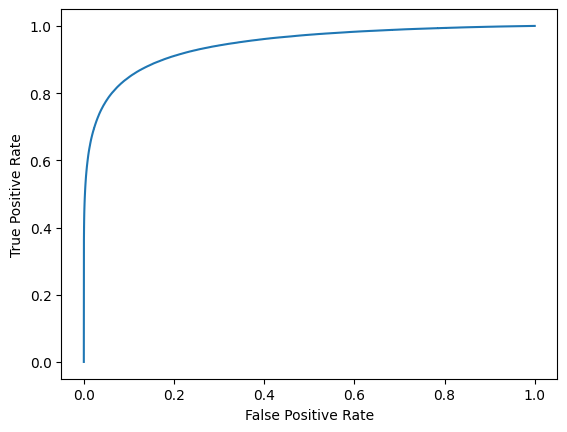

In [24]:
import sklearn.metrics as m

fig, ax = plt.subplots()
fpr, tpr, _ = m.roc_curve(y_true, y_pred)
ax.plot(fpr, tpr, label='ROC curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')

In [ ]:
df_bkg = 

In [38]:
cfg = get_config()

In [34]:
def get_config():
    cfg = SimpleNamespace(
            filelist = {
                'sig': None,
                'bkg': None,
            },
            label_list=[ 'score_label_Top_bWcs','score_label_Top_bWqq','score_label_Top_bWc','score_label_Top_bWs','score_label_Top_bWq','score_label_Top_bWev','score_label_Top_bWmv','score_label_Top_bWtauev','score_label_Top_bWtaumv','score_label_Top_bWtauhv','score_label_Top_Wcs','score_label_Top_Wqq','score_label_Top_Wev','score_label_Top_Wmv','score_label_Top_Wtauev','score_label_Top_Wtaumv','score_label_Top_Wtauhv','score_label_H_bb','score_label_H_cc','score_label_H_ss','score_label_H_qq','score_label_H_bc','score_label_H_bs','score_label_H_cs','score_label_H_gg','score_label_H_ee','score_label_H_mm','score_label_H_tauhtaue','score_label_H_tauhtaum','score_label_H_tauhtauh','score_label_H_WW_cscs','score_label_H_WW_csqq','score_label_H_WW_qqqq','score_label_H_WW_csc','score_label_H_WW_css','score_label_H_WW_csq','score_label_H_WW_qqc','score_label_H_WW_qqs','score_label_H_WW_qqq','score_label_H_WW_csev','score_label_H_WW_qqev','score_label_H_WW_csmv','score_label_H_WW_qqmv','score_label_H_WW_cstauev','score_label_H_WW_qqtauev','score_label_H_WW_cstaumv','score_label_H_WW_qqtaumv','score_label_H_WW_cstauhv','score_label_H_WW_qqtauhv','score_label_H_WxWx_cscs','score_label_H_WxWx_csqq','score_label_H_WxWx_qqqq','score_label_H_WxWx_csc','score_label_H_WxWx_css','score_label_H_WxWx_csq','score_label_H_WxWx_qqc','score_label_H_WxWx_qqs','score_label_H_WxWx_qqq','score_label_H_WxWx_csev','score_label_H_WxWx_qqev','score_label_H_WxWx_csmv','score_label_H_WxWx_qqmv','score_label_H_WxWx_cstauev','score_label_H_WxWx_qqtauev','score_label_H_WxWx_cstaumv','score_label_H_WxWx_qqtaumv','score_label_H_WxWx_cstauhv','score_label_H_WxWx_qqtauhv','score_label_H_WxWxStar_cscs','score_label_H_WxWxStar_csqq','score_label_H_WxWxStar_qqqq','score_label_H_WxWxStar_csc','score_label_H_WxWxStar_css','score_label_H_WxWxStar_csq','score_label_H_WxWxStar_qqc','score_label_H_WxWxStar_qqs','score_label_H_WxWxStar_qqq','score_label_H_WxWxStar_csev','score_label_H_WxWxStar_qqev','score_label_H_WxWxStar_csmv','score_label_H_WxWxStar_qqmv','score_label_H_WxWxStar_cstauev','score_label_H_WxWxStar_qqtauev','score_label_H_WxWxStar_cstaumv','score_label_H_WxWxStar_qqtaumv','score_label_H_WxWxStar_cstauhv','score_label_H_WxWxStar_qqtauhv','score_label_H_ZZ_bbbb','score_label_H_ZZ_bbcc','score_label_H_ZZ_bbss','score_label_H_ZZ_bbqq','score_label_H_ZZ_cccc','score_label_H_ZZ_ccss','score_label_H_ZZ_ccqq','score_label_H_ZZ_ssss','score_label_H_ZZ_ssqq','score_label_H_ZZ_qqqq','score_label_H_ZZ_bbb','score_label_H_ZZ_bbc','score_label_H_ZZ_bbs','score_label_H_ZZ_bbq','score_label_H_ZZ_ccb','score_label_H_ZZ_ccc','score_label_H_ZZ_ccs','score_label_H_ZZ_ccq','score_label_H_ZZ_ssb','score_label_H_ZZ_ssc','score_label_H_ZZ_sss','score_label_H_ZZ_ssq','score_label_H_ZZ_qqb','score_label_H_ZZ_qqc','score_label_H_ZZ_qqs','score_label_H_ZZ_qqq','score_label_H_ZZ_bbee','score_label_H_ZZ_bbmm','score_label_H_ZZ_bbe','score_label_H_ZZ_bbm','score_label_H_ZZ_bee','score_label_H_ZZ_bmm','score_label_H_ZZ_bbtauhtaue','score_label_H_ZZ_bbtauhtaum','score_label_H_ZZ_bbtauhtauh','score_label_H_ZZ_btauhtaue','score_label_H_ZZ_btauhtaum','score_label_H_ZZ_btauhtauh','score_label_H_ZZ_ccee','score_label_H_ZZ_ccmm','score_label_H_ZZ_cce','score_label_H_ZZ_ccm','score_label_H_ZZ_cee','score_label_H_ZZ_cmm','score_label_H_ZZ_cctauhtaue','score_label_H_ZZ_cctauhtaum','score_label_H_ZZ_cctauhtauh','score_label_H_ZZ_ctauhtaue','score_label_H_ZZ_ctauhtaum','score_label_H_ZZ_ctauhtauh','score_label_H_ZZ_ssee','score_label_H_ZZ_ssmm','score_label_H_ZZ_sse','score_label_H_ZZ_ssm','score_label_H_ZZ_see','score_label_H_ZZ_smm','score_label_H_ZZ_sstauhtaue','score_label_H_ZZ_sstauhtaum','score_label_H_ZZ_sstauhtauh','score_label_H_ZZ_stauhtaue','score_label_H_ZZ_stauhtaum','score_label_H_ZZ_stauhtauh','score_label_H_ZZ_qqee','score_label_H_ZZ_qqmm','score_label_H_ZZ_qqe','score_label_H_ZZ_qqm','score_label_H_ZZ_qee','score_label_H_ZZ_qmm','score_label_H_ZZ_qqtauhtaue','score_label_H_ZZ_qqtauhtaum','score_label_H_ZZ_qqtauhtauh','score_label_H_ZZ_qtauhtaue','score_label_H_ZZ_qtauhtaum','score_label_H_ZZ_qtauhtauh','score_label_H_ZxZx_bbbb','score_label_H_ZxZx_bbcc','score_label_H_ZxZx_bbss','score_label_H_ZxZx_bbqq','score_label_H_ZxZx_cccc','score_label_H_ZxZx_ccss','score_label_H_ZxZx_ccqq','score_label_H_ZxZx_ssss','score_label_H_ZxZx_ssqq','score_label_H_ZxZx_qqqq','score_label_H_ZxZx_bbb','score_label_H_ZxZx_bbc','score_label_H_ZxZx_bbs','score_label_H_ZxZx_bbq','score_label_H_ZxZx_ccb','score_label_H_ZxZx_ccc','score_label_H_ZxZx_ccs','score_label_H_ZxZx_ccq','score_label_H_ZxZx_ssb','score_label_H_ZxZx_ssc','score_label_H_ZxZx_sss','score_label_H_ZxZx_ssq','score_label_H_ZxZx_qqb','score_label_H_ZxZx_qqc','score_label_H_ZxZx_qqs','score_label_H_ZxZx_qqq','score_label_H_ZxZx_bbee','score_label_H_ZxZx_bbmm','score_label_H_ZxZx_bbe','score_label_H_ZxZx_bbm','score_label_H_ZxZx_bee','score_label_H_ZxZx_bmm','score_label_H_ZxZx_bbtauhtaue','score_label_H_ZxZx_bbtauhtaum','score_label_H_ZxZx_bbtauhtauh','score_label_H_ZxZx_btauhtaue','score_label_H_ZxZx_btauhtaum','score_label_H_ZxZx_btauhtauh','score_label_H_ZxZx_ccee','score_label_H_ZxZx_ccmm','score_label_H_ZxZx_cce','score_label_H_ZxZx_ccm','score_label_H_ZxZx_cee','score_label_H_ZxZx_cmm','score_label_H_ZxZx_cctauhtaue','score_label_H_ZxZx_cctauhtaum','score_label_H_ZxZx_cctauhtauh','score_label_H_ZxZx_ctauhtaue','score_label_H_ZxZx_ctauhtaum','score_label_H_ZxZx_ctauhtauh','score_label_H_ZxZx_ssee','score_label_H_ZxZx_ssmm','score_label_H_ZxZx_sse','score_label_H_ZxZx_ssm','score_label_H_ZxZx_see','score_label_H_ZxZx_smm','score_label_H_ZxZx_sstauhtaue','score_label_H_ZxZx_sstauhtaum','score_label_H_ZxZx_sstauhtauh','score_label_H_ZxZx_stauhtaue','score_label_H_ZxZx_stauhtaum','score_label_H_ZxZx_stauhtauh','score_label_H_ZxZx_qqee','score_label_H_ZxZx_qqmm','score_label_H_ZxZx_qqe','score_label_H_ZxZx_qqm','score_label_H_ZxZx_qee','score_label_H_ZxZx_qmm','score_label_H_ZxZx_qqtauhtaue','score_label_H_ZxZx_qqtauhtaum','score_label_H_ZxZx_qqtauhtauh','score_label_H_ZxZx_qtauhtaue','score_label_H_ZxZx_qtauhtaum','score_label_H_ZxZx_qtauhtauh','score_label_H_ZxZxStar_bbbb','score_label_H_ZxZxStar_bbcc','score_label_H_ZxZxStar_bbss','score_label_H_ZxZxStar_bbqq','score_label_H_ZxZxStar_cccc','score_label_H_ZxZxStar_ccss','score_label_H_ZxZxStar_ccqq','score_label_H_ZxZxStar_ssss','score_label_H_ZxZxStar_ssqq','score_label_H_ZxZxStar_qqqq','score_label_H_ZxZxStar_bbb','score_label_H_ZxZxStar_bbc','score_label_H_ZxZxStar_bbs','score_label_H_ZxZxStar_bbq','score_label_H_ZxZxStar_ccb','score_label_H_ZxZxStar_ccc','score_label_H_ZxZxStar_ccs','score_label_H_ZxZxStar_ccq','score_label_H_ZxZxStar_ssb','score_label_H_ZxZxStar_ssc','score_label_H_ZxZxStar_sss','score_label_H_ZxZxStar_ssq','score_label_H_ZxZxStar_qqb','score_label_H_ZxZxStar_qqc','score_label_H_ZxZxStar_qqs','score_label_H_ZxZxStar_qqq','score_label_H_ZxZxStar_bbee','score_label_H_ZxZxStar_bbmm','score_label_H_ZxZxStar_bbe','score_label_H_ZxZxStar_bbm','score_label_H_ZxZxStar_bee','score_label_H_ZxZxStar_bmm','score_label_H_ZxZxStar_bbtauhtaue','score_label_H_ZxZxStar_bbtauhtaum','score_label_H_ZxZxStar_bbtauhtauh','score_label_H_ZxZxStar_btauhtaue','score_label_H_ZxZxStar_btauhtaum','score_label_H_ZxZxStar_btauhtauh','score_label_H_ZxZxStar_ccee','score_label_H_ZxZxStar_ccmm','score_label_H_ZxZxStar_cce','score_label_H_ZxZxStar_ccm','score_label_H_ZxZxStar_cee','score_label_H_ZxZxStar_cmm','score_label_H_ZxZxStar_cctauhtaue','score_label_H_ZxZxStar_cctauhtaum','score_label_H_ZxZxStar_cctauhtauh','score_label_H_ZxZxStar_ctauhtaue','score_label_H_ZxZxStar_ctauhtaum','score_label_H_ZxZxStar_ctauhtauh','score_label_H_ZxZxStar_ssee','score_label_H_ZxZxStar_ssmm','score_label_H_ZxZxStar_sse','score_label_H_ZxZxStar_ssm','score_label_H_ZxZxStar_see','score_label_H_ZxZxStar_smm','score_label_H_ZxZxStar_sstauhtaue','score_label_H_ZxZxStar_sstauhtaum','score_label_H_ZxZxStar_sstauhtauh','score_label_H_ZxZxStar_stauhtaue','score_label_H_ZxZxStar_stauhtaum','score_label_H_ZxZxStar_stauhtauh','score_label_H_ZxZxStar_qqee','score_label_H_ZxZxStar_qqmm','score_label_H_ZxZxStar_qqe','score_label_H_ZxZxStar_qqm','score_label_H_ZxZxStar_qee','score_label_H_ZxZxStar_qmm','score_label_H_ZxZxStar_qqtauhtaue','score_label_H_ZxZxStar_qqtauhtaum','score_label_H_ZxZxStar_qqtauhtauh','score_label_H_ZxZxStar_qtauhtaue','score_label_H_ZxZxStar_qtauhtaum','score_label_H_ZxZxStar_qtauhtauh','score_label_QCD_bb','score_label_QCD_cc','score_label_QCD_b','score_label_QCD_c','score_label_QCD_others']
    )
    variable_dict = {
        'QCD': [ 'score_label_QCD_bb','score_label_QCD_cc','score_label_QCD_b','score_label_QCD_c','score_label_QCD_others'],
        'HWW': ['score_label_H_WW_cscs','score_label_H_WW_csqq','score_label_H_WW_qqqq','score_label_H_WW_csc','score_label_H_WW_css','score_label_H_WW_csq','score_label_H_WW_qqc','score_label_H_WW_qqs','score_label_H_WW_qqq','score_label_H_WW_csev','score_label_H_WW_qqev','score_label_H_WW_csmv','score_label_H_WW_qqmv','score_label_H_WW_cstauev','score_label_H_WW_qqtauev','score_label_H_WW_cstaumv','score_label_H_WW_qqtaumv','score_label_H_WW_cstauhv','score_label_H_WW_qqtauhv']
    }
    label_dict = {
        'QCD': ['QCD'],
        'HWW': ['HWW']
    }
    return cfg
